# Wake deficit model optimization
ChatGPT aided in som library and asset use.


In [13]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.literature.noj import Jensen_1983
from py_wake.superposition_models import LinearSum, SquaredSum
from swt6 import SWT6
from dudgeon import NAMES, WT_X, WT_Y
import numpy as np
import pandas as pd
from data_filter import prepare_turbine_seperated_data
from sklearn.model_selection import train_test_split


### Defining the parameter grid

In [11]:
param_grid = {
    'deficitModel': [Jensen_1983, Bastankhah_PorteAgel_2014],
    'superpositionModel': [LinearSum, SquaredSum],
    'k': np.linspace(start=0.01, stop= 0.1, num=12)
}


### Defining test and trainset 

In [67]:

def get_ws_dataset(data):
    ws_df = None
    for name, df_i in data.items():
        df_i = df_i.rename(columns= {'WindSpeed': name})
        if name == 'A01':
            ws_df = df_i[name]
        else:
            ws_df = pd.merge(ws_df, df_i[name], on='timestamp', how='inner')
    ws_df = pd.merge(ws_df, data['A05']['WindDirection'], on='timestamp', how='inner')
    return ws_df

In [68]:
data = prepare_turbine_seperated_data()
ws_dataset = get_ws_dataset(data=data)
ws_dataset = ws_dataset[ws_dataset['WindDirection'] > 140]

### Reason for limited dataset

In [79]:
def print_missing_ws_values(data):
    ws_df = None
    for name, df_i in data.items():
        df_i = df_i.rename(columns= {'WindSpeed': name})
        if name == 'A01':
            ws_df = df_i[name]
        else:
            ws_df = pd.merge(ws_df, df_i[name], on='timestamp', how='outer')
    ws_df = pd.merge(ws_df, data['A05']['WindDirection'], on='timestamp', how='outer')
    print(ws_df.isna().sum())

print_missing_ws_values(data)

TypeError: print_missing_ws_values() missing 1 required positional argument: 'data'

### Showing wind directions

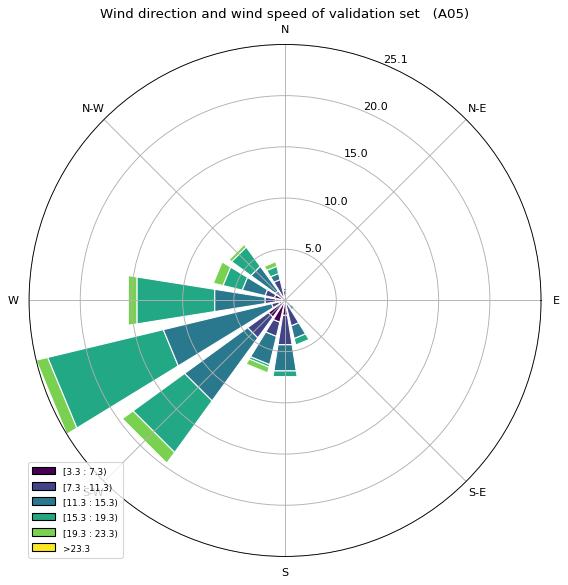

In [69]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

ax_wd = WindroseAxes.from_ax()
ax_wd.bar(ws_dataset['WindDirection'], ws_dataset['A05'], normed=True, opening=0.8, edgecolor='white')
ax_wd.set_legend()
ax_wd.set_title("Wind direction and wind speed of validation set   (A05)")
plt.show()

### Defining objective function

In [75]:
from tqdm import tqdm
from wake_estimator import WakeEstimator

ws_source_turbine = 'A05'
def objective_function(estimator: WakeEstimator):
    y_val = ws_dataset[NAMES].to_numpy()

    def get_mse(y_val, y_pred):
        mse = np.mean(np.square(y_val - y_pred))
        return mse
    
    y_pred = []
    for _, row in tqdm(ws_dataset.iterrows(), total=len(ws_dataset), desc='Calculating MSE'):
        x_i = (row[ws_source_turbine], row['WindDirection'])
        y_pred_i = estimator.predict(x_i)
        y_pred.append(y_pred_i)
    y_pred = np.array(y_pred)
    return get_mse(y_val, y_pred)



In [78]:
test_estimator = WakeEstimator(deficitModel=Jensen_1983, superpositionModel=LinearSum, k=0.04)
test_mse = objective_function(test_estimator)
print(test_mse)

Calculating MSE:   0%|          | 0/2742 [00:00<?, ?it/s]

Calculating MSE: 100%|██████████| 2742/2742 [00:46<00:00, 58.99it/s]

1.8441818365853329
